# OCR Document sorting according to Date


Down below you can see the first trial of loading an image and trying to extract the highest date found in the document. Since there might be multiple dates presented in a document we make an assumption that the date with highest Y coordinate here is the successor and the creation date of the document. We look at both formats of DD.MM.YYYY and DD/MM/YYYY. 

The tesseract libarary that is used for Optical Character Recognition has different page scan methods. These very from row method to block search and straight line read. In this project from trial and error I decided to go for PSM 6 which is the block search methods as document creation dates tend to be in blocks.

In [1]:
import cv2
import pytesseract
import re

# Load the image
image = cv2.imread('test.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Perform OCR on the entire document
extracted_text = pytesseract.image_to_string(gray, config='--psm 6')  # Use PSM 6 for block of text

# Search for dates in the extracted text (both "DD.MM.YYYY" and "MM/DD/YYYY" formats)
date_pattern = r'\d{2}.\d{2}.\d{4}|\d{2}/\d{2}/\d{4}'
dates = re.findall(date_pattern, extracted_text)

# Find the date closest to the top of the document
highest_date = None
highest_date_y = None

for date in dates:
    date_y = 0  # Set Y-coordinate to 0 (top of the document)
    if highest_date_y is None or date_y < highest_date_y:
        highest_date = date
        highest_date_y = date_y

if highest_date:
    print("Date found at the top of the document:", highest_date)
else:
    print("No date found in the document.")



Date found at the top of the document: 11/13/2021


**Note**: I also tested the OCR with handwriting to see if it would be able to read writings but it failed and reasearch displayed that making it compatible with handwritings requires more resources and training which at the end wont be very accurate since handwritings vary a lot. For the aim of this project regarding sorting documents the scanning of printed text is  statisfactory since nowadays creation of documents tend to be printed anyway.

### Getting dates from multiple documents 

Now we make an attempt to get dates from all the documents that reside in current paths /images folder and ordering them from the oldest to newest since the older the document is the higher the priority of its review is. This is part of the sorting now, we also have 2 arrays one of them being used for the documents with dates and other without.

I made it so that program accepts images of format .jpg and .png thinking these would be most often used, but these can be adjusted for future need.

The method of finding the date with highest y-coordinate also changed for optimizing it and in effort to cleanup the code.



In [2]:
import os
import cv2
import pytesseract
import re

# Specify the directory containing the documents
document_directory = os.path.join(os.getcwd(), 'images')

# Initialize lists to store dates and documents without dates
all_dates = []
documents_without_dates = []

# Loop through all files in the directory
for filename in os.listdir(document_directory):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust for supported image file types
        file_path = os.path.join(document_directory, filename)

        # Load the image
        image = cv2.imread(file_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Perform OCR on the entire document
        extracted_text = pytesseract.image_to_string(gray, config='--psm 6')  # Use PSM 6 for block of text

        # Search for dates in the extracted text (both "DD.MM.YYYY" and "MM/DD/YYYY" formats)
        date_pattern = r'\d{2}.\d{2}.\d{4}|\d{2}/\d{2}/\d{4}'
        dates = re.findall(date_pattern, extracted_text)

        if dates:
            # Find the date closest to the top of the document
            highest_date = min(dates, key=lambda date: extracted_text.find(date))
            all_dates.append((filename, highest_date))
        else:
            documents_without_dates.append(filename)

# Display the top dates
if all_dates:
    sorted_dates = sorted(all_dates, key=lambda item: extracted_text.find(item[1]))
    print("Top dates from each document in order:")
    for document, date in sorted_dates:
        print(f"Document: {document}, Date: {date}")

# Display documents without dates
if documents_without_dates:
    print("Documents with no date found:")
    for document in documents_without_dates:
        print(document)



Top dates from each document in order:
Document: Picture1.png, Date: 23/12/2020
Document: Picture2.png, Date: 22/31/2005
Document: Picture3.png, Date: 22/31/2005
Document: Picture4.png, Date: 22/31/2005
Document: Picture5.png, Date: 22/31/2005
Document: test.png, Date: 11/13/2021
Document: test2.png, Date: 19.09.2022
Document: test4.png, Date: 05.08.2023
Documents with no date found:
NoDate_1.jpg
Picture6.png


### Sorting the documents in a new path

Okay, now we can read the dates from multiple files and put them order. Its time to rename these documents and sort them out in a new path. We also have to consider the documents that OCR couldnt find any date in, for these we will be calling them NoDate_(increment). But for the documents that have dates we will have Document(increment) starting from the oldest date to the newest date. 

We also included a error code if the directory given is empty.

To do the copying of the documents to a new path we import a new libarary 'copy2' and for sorting we have a for loop.

In [3]:
import os
import cv2
import pytesseract
import re
from shutil import copy2

# Specify the directory containing the documents
document_directory = os.path.join(os.getcwd(), 'images')

# Check if the directory is empty
if not os.listdir(document_directory):
    print("Error: No documents found in the directory.")
    exit()

# Create a folder for the sorted documents
sorted_documents_folder = 'Sorted_Documents'
if not os.path.exists(sorted_documents_folder):
    os.makedirs(sorted_documents_folder)

# Initialize lists to store dates and documents without dates
all_dates = []
documents_without_dates = []

# Loop through all files in the directory
for filename in os.listdir(document_directory):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust for supported image file types
        file_path = os.path.join(document_directory, filename)

        # Load the image
        image = cv2.imread(file_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Perform OCR on the entire document
        extracted_text = pytesseract.image_to_string(gray, config='--psm 6')  # Use PSM 6 for block of text

        # Search for dates in the extracted text (both "DD.MM.YYYY" and "MM/DD/YYYY" formats)
        date_pattern = r'\d{2}.\d{2}.\d{4}|\d{2}/\d{2}/\d{4}'
        dates = re.findall(date_pattern, extracted_text)

        if dates:
            # Find the date closest to the top of the document
            highest_date = min(dates, key=lambda date: extracted_text.find(date))
            all_dates.append((filename, highest_date))
        else:
            documents_without_dates.append(filename)

# Sort documents by date
if all_dates:
    sorted_dates = sorted(all_dates, key=lambda item: extracted_text.find(item[1]))

    # Copy sorted documents to the sorted folder
    for i, (document, date) in enumerate(sorted_dates):
        new_document_name = f'Document_{i+1}.jpg'  # Rename as Document_(Increment)
        new_document_path = os.path.join(sorted_documents_folder, new_document_name)
        copy2(os.path.join(document_directory, document), new_document_path)

    # Copy documents without dates to the same folder
if documents_without_dates:
    for i, document in enumerate(documents_without_dates):
        new_document_name = f'NoDate_{i+1}.jpg'  # Rename as NoDate_(Increment)
        new_document_path = os.path.join(sorted_documents_folder, new_document_name)
        copy2(os.path.join(document_directory, document), new_document_path)
        
    # Display documents without dates
    print("Documents with no date found:")
    for document in documents_without_dates:
        print(document)


print("Documents have been sorted and renamed in the 'Sorted_Documents' folder. The documents with no date have been named as NoDate_(i)")


Documents with no date found:
NoDate_1.jpg
Picture6.png
Documents have been sorted and renamed in the 'Sorted_Documents' folder. The documents with no date have been named as NoDate_(i)


### Results and testing 

As it can be seen above if there are no dates found in the documents the reporting works. Now lets see the images that it put in the path. Are the namings correct? Did it produce results?

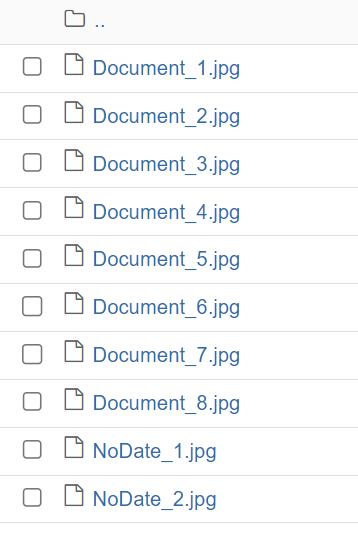

In [4]:
from IPython.display import Image
Image(filename='results.png') 

As you can see the code works well and the files are sorted. While testing the code I also realized that if there are more then one date that are in the same Y coordinate then the code takes the older date which is reasonable in our case.

That concludes the program and its a demonstration of use of OCR to find dates of the documents. This is just one demonstration of how OCR could be used to digitalize real life issues and do it very efficiently and with no hustle. 